In [ ]:
# %matplotlib nbagg
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import os
import time
sys.path.append("..")
os.chdir("/home/nakamura/HAI/main_server/hai")

import coloredlogs, logging
logger = logging.getLogger(__name__)
coloredlogs.install(level='CRITICAL', logger=logger)

import pymongo
from pymongo import MongoClient
from PIL import Image
from matplotlib import pylab as plt
from matplotlib.animation import ArtistAnimation
import matplotlib.animation as animation
import numpy as np
from bson.objectid import ObjectId
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from notebooks.utils.utils import visualize, display_latest_image, display_image, print_time, strtime_to_epoch, epoch_to_strtime, UpdateDist, display_two_images
from controllers.actionrec import ActionRecognition
from controllers.dbreader.hue_koki_dbreader import HueDBReader, pair_images, extract_color, ExprHueDBReader
from controllers.dbreader.opedbreader import OperationDBReader, collect_img_op
from controllers.dbreader.imagereader import ImageReader
from controllers.vectorizer.posennvectorizer import PoseNNVectorizer
from controllers.vectorizer.person2vec import Person2Vec

mongo = MongoClient('localhost', 20202).hai

from flask import Flask
app = Flask(__name__)
app.config.from_pyfile(filename="application.cfg")

In [3]:
# make movie
start = strtime_to_epoch("2017-12-19 23:45:00")
end = time.time()
# img0_cols = mongo.images.find({'cam_id': 'webcam0', 'time': {'$gt': start, '$lt': end}})
# img1_cols = mongo.images.find({'cam_id': 'webcam1', 'time': {'$gt': start, '$lt': end}})
# imgs_cols = np.array(pair_images(img0_cols, img1_cols))
# len(imgs_cols)

In [86]:
# %matplotlib nbagg
# fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
# ud = UpdateDist(axL, axR, imgs_cols)
# ani = animation.FuncAnimation(fig, ud, frames=range(ud.length), interval=1000)
# ani.save('1219-kanada.mp4', writer="ffmpeg")
# fig.show()

In [91]:
exprDBreader = ExprHueDBReader('koki')
X, y = exprDBreader.read_db(start, end)
len(X), len(y)

(1194, 1194)

In [92]:
# %matplotlib nbagg
# fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
# ud = UpdateDist(axL, axR, X, info=y)
# ani = animation.FuncAnimation(fig, ud, frames=range(ud.length), interval=200)
# ani.save('1219-kanada-labeled.mp4', writer="ffmpeg")
# # fig.show()

In [93]:
pose_nn_vectroizer = PoseNNVectorizer('koki', debug=True)

In [96]:
X_arr, y_arr = pose_nn_vectroizer.vectorize(X, y, color_augmentation_times=1)

100%|██████████| 1194/1194 [03:58<00:00,  5.25it/s]

In [101]:
clf = RandomForestClassifier()
# clf = linear_model.SGDClassifier(loss='log')
pipe = Pipeline([
            ("scale", StandardScaler()),
            ("pca", PCA(n_components=50)),
            ("clf", clf)
    ])
cross_validation.cross_val_score(pipe, X_arr, y_arr, cv=5)

array([ 0.87916667,  0.87866109,  0.90794979,  0.8697479 ,  0.8907563 ])

In [160]:
ops = mongo.operation.find({'controller': 'IRKit', 'operation.0.data.0': 'TV', 'time': {"$gte": start, "$lt": end}})

In [161]:
start_op = ops.next()
end = ops.next()

In [210]:
X, y = collect_img_op('koki', start=start, end=end)

In [178]:
len(X), len(y)

(1231, 1231)

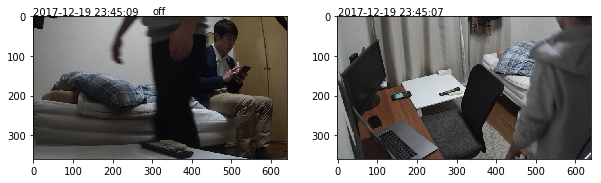

In [179]:
# %matplotlib nbagg
# fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
# ud = UpdateDist(axL, axR, X, info=y)
# ani = animation.FuncAnimation(fig, ud, frames=range(ud.length), interval=200)
# ani.save('1219-kanada-tv.mp4', writer="ffmpeg")
# fig.show()

In [185]:
X_arr, y_arr = pose_nn_vectroizer.vectorize(X, y, color_augmentation_times=1)


 25%|██▍       | 303/1231 [01:02<02:54,  5.32it/s]


 49%|████▉     | 605/1231 [02:03<02:09,  4.83it/s]


 74%|███████▎  | 907/1231 [03:03<01:02,  5.21it/s]


 98%|█████████▊| 1205/1231 [04:04<00:04,  5.37it/s]


100%|██████████| 1231/1231 [04:09<00:00,  5.37it/s]


In [186]:
y_arr = LabelEncoder().fit_transform(y_arr)

In [193]:
clf = RandomForestClassifier()
# clf = linear_model.SGDClassifier(loss='log')
pipe = Pipeline([
            ("scale", StandardScaler()),
            ("pca", PCA(n_components=50)),
            ("clf", clf)
    ])
cross_validation.cross_val_score(pipe, X_arr, y_arr, cv=5)
# X_train, X_val, y_train, y_val = train_test_split(X_arr, y_arr, train_size=0.6, random_state=1)
# pipe.fit(X_train, y_train)
# y_predicted = pipe.predict(X_val)

/home/nakamura/.pyenv/versions/anaconda3-4.4.0/envs/detection_server/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [218]:
imreader = ImageReader()
start_time = start
end_time = end
imdata = imreader.read_db('koki', start_time, end_time, ['webcam0', 'webcam1'])

In [4]:
exprDBreader = ExprHueDBReader('koki')
X, y = exprDBreader.read_db(start, end)
len(X), len(y)

(1194, 1194)

In [5]:
person2vectorizer = Person2Vec()

In [7]:
pose_arr, act_arr, meta = person2vectorizer.vectorize(X, get_meta=True)

In [10]:
pose_arr.shape, act_arr.shape

((1194, 108), (1194, 2048))

In [12]:
y_arr = LabelEncoder().fit_transform(y)

195

In [14]:
clf = RandomForestClassifier()
# clf = linear_model.SGDClassifier(loss='log')
pipe = Pipeline([
            ("scale", StandardScaler()),
            ("pca", PCA(n_components=50)),
            ("clf", clf)
    ])
cross_validation.cross_val_score(pipe, pose_arr, y_arr, cv=5)
# X_train, X_val, y_train, y_val = train_test_split(X_arr, y_arr, train_size=0.6, random_state=1)
# pipe.fit(X_train, y_train)
# y_predicted = pipe.predict(X_val)

array([ 0.95      ,  0.9665272 ,  0.9707113 ,  0.97478992,  0.87394958])

In [15]:
clf = RandomForestClassifier()
# clf = linear_model.SGDClassifier(loss='log')
pipe = Pipeline([
            ("scale", StandardScaler()),
            ("pca", PCA(n_components=50)),
            ("clf", clf)
    ])
cross_validation.cross_val_score(pipe, act_arr, y_arr, cv=5)
# X_train, X_val, y_train, y_val = train_test_split(X_arr, y_arr, train_size=0.6, random_state=1)
# pipe.fit(X_train, y_train)
# y_predicted = pipe.predict(X_val)

array([ 0.93333333,  0.9874477 ,  0.9832636 ,  0.9789916 ,  0.9789916 ])

In [ ]:
action_rec = ActionRecognition()

In [ ]:
for img_col in imgs_cols:
    action_rec.on_event('image', )